In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
import polars as pl

from tqdm import tqdm
from PIL import Image
from utils import decompose_projection_matrix, get_P, get_K, compute_depth_hypothesis, get_global_params, get_all_extrinsic_params
from einops import rearrange

### Plot depth map

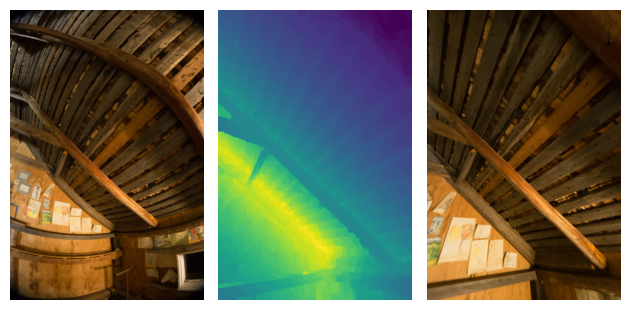

In [33]:
dense_path = "../res/dense/depthmaps"
source_path = "../res/source"
undistorted_path = "../res/sparse/undistorted"

im_index = "001"

source_im = imread(os.path.join(source_path, f"{im_index}.jpg"))
undistorted_im = imread(os.path.join(undistorted_path, f"{im_index}.jpg"))
depth_im = imread(os.path.join(dense_path, f"{im_index}.png"))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(source_im)
ax1.axis("off")
ax2.imshow(depth_im)
ax2.axis("off")
ax3.imshow(undistorted_im)
ax3.axis("off")
plt.tight_layout()

Depth estimation using undistorted version of the captured images.

### Convert Points3D.txt to .parquet

In [19]:
root_model = "res/sparse/model"

cols = ["POINT3D_ID", "X", "Y", "Z", "R", "G", "B", "ERROR", "TRACK[]_as_(IMAGE_ID,POINT2D_IDX)"]
# Number of points: 92890, mean track length: 5.08172

with open(os.path.join(root_model, "points3D.txt"), "r") as f:
    for _ in range(3):
        f.readline() # skip header

    lines = f.readlines()


def parse_line(line):
    parts = line.strip().split()

    point3d_id = int(parts[0])
    x, y, z = map(float, parts[1:4])
    r, g, b = map(int, parts[4:7])
    error = float(parts[7])
    
    # Remaining values are in (IMAGE_ID, POINT2D_IDX) pairs
    track = [(int(parts[i]), int(parts[i + 1])) for i in range(8, len(parts), 2)]
    
    return (point3d_id, x, y, z, r, g, b, error, track)

# Parse all lines
parsed_data = [parse_line(line) for line in lines]

# Create Polars DataFrame
df = pl.DataFrame(
    parsed_data,
    schema=cols
)

# df.write_parquet(os.path.join(root_model, "points3D.parquet"))

### Convert images.txt to .parquet

In [23]:
cols = "IMAGE_ID", "QW", "QX", "QY", "QZ", "TX", "TY", "TZ", "CAMERA_ID", "NAME", "POINTS2D[]_as_(X,Y,POINT3D_ID)"


with open(os.path.join(root_model, "images.txt"), "r") as f:
    for _ in range(4):
        f.readline()  # Skip header
    lines = f.readlines()

# Ensure we process pairs of lines
assert len(lines) % 2 == 0, "File format is incorrect: lines should be in pairs."

def parse_pair(meta_line, points_line):
    meta_parts = meta_line.strip().split()
    points_parts = points_line.strip().split()

    # Extract metadata from the first line
    image_id = int(meta_parts[0])
    qw, qx, qy, qz = map(float, meta_parts[1:5])
    tx, ty, tz = map(float, meta_parts[5:8])
    camera_id = int(meta_parts[8])
    name = meta_parts[9]  # The filename (string)

    # Extract points_2D from the second line, ensuring proper typing
    points_2D = [
        (float(points_parts[i]), float(points_parts[i + 1]), float(points_parts[i + 2]))
        for i in range(0, len(points_parts), 3)
    ]

    return (image_id, qw, qx, qy, qz, tx, ty, tz, camera_id, name, points_2D)

parsed_data = [parse_pair(lines[i], lines[i + 1]) for i in range(0, len(lines), 2)]

df = pl.DataFrame(
    parsed_data,
    schema=cols
)

df.write_parquet(os.path.join(root_model, "images.parquet"))

/usr/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


In [6]:
images_df = pl.read_parquet("res/sparse/model/images.parquet")
points_df = pl.read_parquet("res/sparse/model/points3D.parquet")

In [7]:
images_df

shape: (50, 11)
┌──────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬────────────┬───────────┐
│ IMAGE_ID ┆ QW        ┆ QX        ┆ QY        ┆ … ┆ TZ       ┆ CAMERA_ID ┆ NAME       ┆ POINTS2D[ │
│ ---      ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---      ┆ ---       ┆ ---        ┆ ]_as_(X,Y │
│ i64      ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64      ┆ i64       ┆ str        ┆ ,POINT3D_ │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ ID)       │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ ---       │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ list[list │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ [f64]]    │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪════════════╪═══════════╡
│ 1        ┆ -0.488472 ┆ -0.280591 ┆ 0.81914   ┆ … ┆ -3.04357 ┆ 1         ┆ ldr/creepy ┆ [[54.784, │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ attic_0003 ┆ 12.975,   │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ .jpg       ┆ -1.0],    │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ [86.0…    │
│ 2        ┆ 0.563159  ┆ -0.060981 ┆ -0.609996 ┆ … ┆ -2.68216 ┆ 1         ┆ ldr/creepy ┆ [[112.492 │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ attic_0006 ┆ ,         │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ .jpg       ┆ 77.3008,  │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ -1.0],    │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ [10…      │
│ 3        ┆ -0.393841 ┆ -0.223818 ┆ 0.889252  ┆ … ┆ -3.2407  ┆ 1         ┆ ldr/creepy ┆ [[108.863 │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ attic_0009 ┆ ,         │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ .jpg       ┆ 65.5852,  │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ -1.0],    │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ [10…      │
│ 4        ┆ -0.440466 ┆ 0.0470181 ┆ 0.695399  ┆ … ┆ -2.96647 ┆ 1         ┆ ldr/creepy ┆ [[15.5087 │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ attic_0012 ┆ ,         │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ .jpg       ┆ 12.5388,  │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ -1.0],    │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ [90…      │
│ 5        ┆ -0.295292 ┆ -0.138807 ┆ 0.944121  ┆ … ┆ -3.31681 ┆ 1         ┆ ldr/creepy ┆ [[48.8417 │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ attic_0015 ┆ ,         │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ .jpg       ┆ 24.7324,  │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ -1.0],    │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ [77…      │
│ …        ┆ …         ┆ …         ┆ …         ┆ … ┆ …        ┆ …         ┆ …          ┆ …         │
│ 46       ┆ 0.760215  ┆ -0.056664 ┆ -0.465825 ┆ … ┆ -2.98788 ┆ 1         ┆ ldr/creepy ┆ [[157.361 │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ attic_0138 ┆ ,         │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆ .jpg       ┆ 95.6087,  │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ -1.0],    │
│          ┆           ┆           ┆           ┆   ┆          ┆           ┆            ┆ [16…      │
│ 47       ┆ 0.543056  ┆ 0.349226  ┆ -0.76258

### Test on a single image

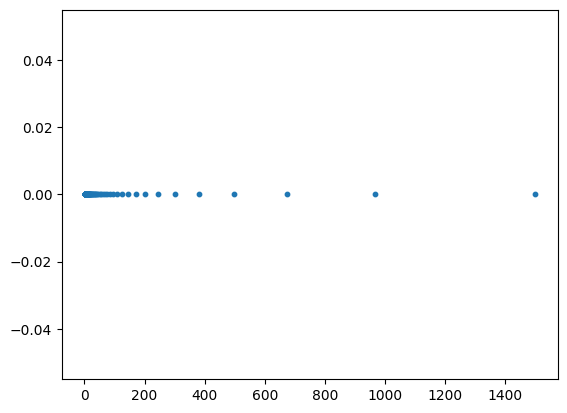

In [2]:
cfg = get_global_params("../res/params.txt")

dmin = cfg["minDepthForScene"] * cfg["colmapToMeters"]
dmax = cfg["maxDepthForScene"] * cfg["colmapToMeters"]
N = 220
dhyp = compute_depth_hypothesis(N, dmin, dmax)
dhyp_colmap = dhyp / cfg["colmapToMeters"]
plt.scatter(dhyp, [0 for _ in range(len(dhyp))], s=10)
plt.show()

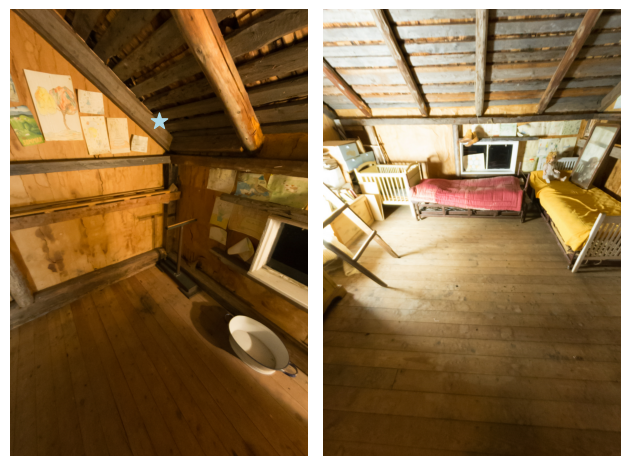

In [3]:
root = "../res/sparse/undistorted"

# The same camera was used for every image
K = get_K(f"{root}/000.jpg.camera.txt")
K_inv = np.linalg.inv(K)

# _a = ANCHOR
im_a = imread(f"{root}/000.jpg")
P_a = get_P(f"{root}/000.jpg.proj_matrix.txt")
R_a, t_a = decompose_projection_matrix(P_a, K)

# _t = TARGET
im_t = imread(f"{root}/030.jpg")
P_t = get_P(f"{root}/030.jpg.proj_matrix.txt")

d = dhyp[150] # depth hypothesis

rows, cols, _ = im_a.shape
col_a, row_a = cols//2, rows//4 # width, height

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(col_a, row_a, marker="*", c="lightblue", s=150)
ax1.imshow(im_a)
ax1.axis("off")
ax2.imshow(im_t)
ax2.axis("off")
plt.tight_layout()

In [8]:
def compute_target_coords(row_a: int, # anchor row
                          col_a: int, # anchor column
                          R_a: np.ndarray, # extrinsic rotation
                          t_a: np.ndarray, # extrinsic translation
                          d: float, # depth hypothesis in COLMAP coordinates
                          R_t: np.ndarray, # target rotation
                          t_t: np.ndarray,
                          fx: float,
                          fy: float,
                          cx: float,
                          cy: float): # target translation
    # u = col
    # v = row
    row_cam = (row_a - cy) / fy
    col_cam = (col_a - cx) / fx
    P_cam = d * np.array([col_cam, row_cam, 1]) # Camera 3D coordinates with distance
    P_world = R_a.T @ (P_cam - t_a) # Transformation of anchor image
    P_cam_new = R_t @ P_world + t_t # 3D coordinates in target image frame of reference
    row_t = (P_cam_new[1] * fy / P_cam_new[2]) + cy
    col_t = (P_cam_new[0] * fx / P_cam_new[2]) + cx
    return row_t, col_t


# For one target image
def compute_target_coords(anchor_coords: np.ndarray,
                          R_a: np.ndarray,
                          t_a: np.ndarray,
                          d: float, 
                          R_t: np.ndarray,
                          t_t: np.ndarray,
                          fx: float,
                          fy: float,
                          cx: float,
                          cy: float):
    n_pixels = len(anchor_coords)
    reversed_anchor_coords = anchor_coords[:,::-1] # (cols rows) instead of rows, cols
    cam_coords = (reversed_anchor_coords - np.array([cx, cy])) / np.array([fx, fy]) # (n_pixels, 2)
    P_cam = d * np.concatenate((cam_coords, np.ones(n_pixels)[:,None]), axis=-1) # Camera 3D coordinates with distance (n_pixels, 3)
    P_world = (P_cam - t_a) @ R_a.T # World 3D coordinates (n_pixels, 3)
    P_cam_new = P_world @ R_t + t_t # (n_pixels, 3)
    col_t = (P_cam_new[:, 0] * fx / P_cam_new[:, 2]) + cx
    row_t = (P_cam_new[:, 1] * fy / P_cam_new[:, 2]) + cy
    target_coords = np.column_stack((row_t, col_t)).round().astype(int)
    return target_coords # rows, cols


# For N target images
def compute_target_coords(anchor_coords: np.ndarray, # (n_pixels, 2)
                          R_a: np.ndarray, # (3, 3)
                          t_a: np.ndarray, # (3,)
                          d: float,
                          R_t: np.ndarray, # (n_target_images, 3, 3)
                          t_t: np.ndarray, # (n_target_images, 3)
                          fx: float,
                          fy: float,
                          cx: float,
                          cy: float):

    n_pixels = len(anchor_coords)
    reversed_anchor_coords = anchor_coords[:,::-1] # (cols rows) instead of rows, cols
    cam_coords = (reversed_anchor_coords - np.array([cx, cy])) / np.array([fx, fy]) # (n_pixels, 2)
    P_cam = d * np.concatenate((cam_coords, np.ones(n_pixels)[:,None]), axis=-1) # Camera 3D coordinates with distance (n_pixels, 3)
    P_world = (P_cam - t_a) @ R_a.T # World 3D coordinates (n_pixels, 3)

    P_cam_new = P_world @ R_t + t_t[:,None,:] # (n_target_images, n_pixels, 3)
    col_t = (P_cam_new[:, :, 0] * fx / P_cam_new[:, :, 2]) + cx # (n_target_images, n_pixels)
    row_t = (P_cam_new[:, :, 1] * fy / P_cam_new[:, :, 2]) + cy # (n_target_images, n_pixels)
    target_coords = np.stack((row_t, col_t), axis=-1)
    return target_coords # rows, cols # (n_target_images, n_pixels, 2)


def compute_flattened_coords(n_rows, n_cols):
    grid = np.stack(np.meshgrid(np.arange(rows), np.arange(cols), indexing="ij"), axis=-1)
    grid_flattened = rearrange(grid, "r c d -> (r c) d")
    return grid_flattened

g = compute_flattened_coords(rows, cols)
# for d in dhyp_colmap:
    # res = compute_target_coords(g, R_a, t_a, d, R_a[None,...], t_a[None,:], fx, fy, cx, cy)
res = compute_target_coords(g, R_a, t_a, 9, all_R, all_t, fx, fy, cx, cy)

In [7]:
all_R = np.stack([R_a for _ in range(10)], axis=0)
all_t = np.stack([t_a for _ in range(10)], axis=0)

all_t.shape, all_R.shape

((10, 3), (10, 3, 3))

In [192]:
%%timeit
compute_target_coords(grid_flattened, R_a, t_a, 9, R_a, t_a, fx, fy, cx, cy)

32.1 μs ± 582 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


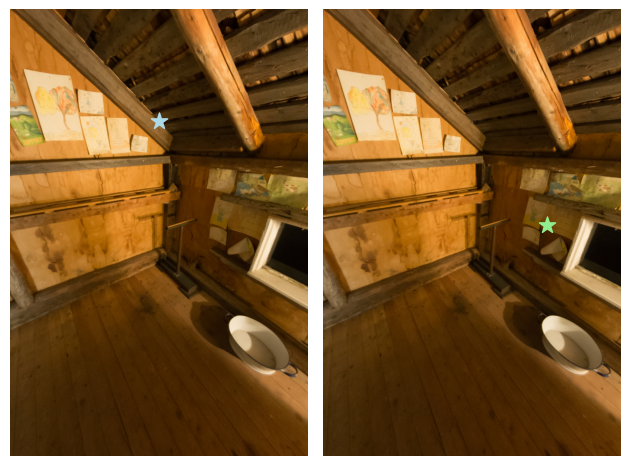

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(col_a, row_a, marker="*", c="lightblue", s=150)
ax1.imshow(im_a)
ax1.axis("off")
ax2.scatter(col_t, row_t, marker="*", c="lightgreen", s=150)
ax2.imshow(im_a)
ax2.axis("off")
plt.tight_layout()

Given one image, compute the projection of a pixel on all the other images. If the projected point is out of bounds, discard the image. For each pixel, the 220 depth hypothesis must be tested.

```code
Input:
- anchor image of shape (n_rows, n_cols, channels)
- target images

initialize `depths` of shape (n_rows, n_cols)
for each pixel in anchor image:
    initialize `loss` array of shape `(n_depth,)`

    for d in depths:
        project on all images with depth hypothesis d
        discard target image if coordinates are out of bound
        compute the loss using sad for all kept images

    keep the depth corresponding to the lowest energy value
```

In [147]:
def load_image_data(root: str):
    im_files = []
    im_projs = []
    for f in os.listdir(root):
        if f.endswith(".jpg"):
            im_files.append(f)
        if "proj_matrix" in f:
            im_projs.append(f)
        
    im_files = sorted(im_files)
    im_projs = sorted(im_projs)

    ims = {}
    projs = {}

    for im_file, im_proj in zip(im_files, im_projs):
        ims[im_file[:-4]] = imread(f"{root}/{im_file}")
        projs[im_file[:-4]] = get_projection(f"{root}/{im_file}.proj_matrix.txt")

    return ims, projs
    


ims, projs = load_image_data(root)

In [160]:
im_a_name = "000"
im_a = ims[im_a_name]
rows, cols, chan = im_a.shape # Every image has the same shape
grid = np.stack(np.meshgrid(np.arange(rows), np.arange(cols), indexing="ij"), axis=-1)

def in_bounds(rows_ref: int, cols_ref: int, row_t: int, col_t: int):
    print("NOT IN BOUND")
    return (0 <= row_t < rows_ref) and (0 <= col_t < cols_ref)

In [ ]:
depths = np.zeros((rows, cols))
image_proj_freq = [] # TEMP: keep track count the number of images seeing each pixel of the anchor image
for row_a in range(rows): # Anchor row
    for col_a in tqdm(range(cols)): # Column row
        energies_per_depth = np.zeros(N) # As many as depth hypothesis
        for d in dhyp:
            n_projections = 0 # Number of images containing the pixel at stake for a candidate depth
            for im_name, P_t in projs.items():
                if im_name == im_a_name: continue # skip anchor image
                col_t, row_t = compute_target_coords(row_a, col_a, d, K_inv, P_t)
                if not in_bounds(rows, cols, row_t, col_t): continue # discard image if the outputted coordinates are out of bound
                n_projections += 1
            # print(n_projections)
# plt.hist(image_proj_freq)
# plt.show()

  0%|          | 1/2372 [00:00<06:30,  6.07it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  0%|          | 2/2372 [00:00<06:18,  6.26it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  0%|          | 4/2372 [00:00<06:07,  6.44it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  0%|          | 5/2372 [00:00<06:17,  6.27it/s]


NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUN

  0%|          | 6/2372 [00:00<06:15,  6.30it/s]


NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUN

  0%|          | 8/2372 [00:01<06:20,  6.22it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  0%|          | 9/2372 [00:01<06:38,  5.92it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  0%|          | 10/2372 [00:01<06:33,  6.00it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  0%|          | 11/2372 [00:01<06:29,  6.06it/s]


NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUN

  1%|          | 13/2372 [00:02<06:43,  5.85it/s]


NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUN

  1%|          | 14/2372 [00:02<06:48,  5.77it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  1%|          | 15/2372 [00:02<06:57,  5.64it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  1%|          | 16/2372 [00:02<06:53,  5.70it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  1%|          | 17/2372 [00:02<06:53,  5.70it/s]


NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUN

  1%|          | 19/2372 [00:03<06:59,  5.62it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  1%|          | 20/2372 [00:03<06:54,  5.67it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

  1%|          | 20/2372 [00:03<06:50,  5.73it/s]

NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND
NOT IN BOUND

KeyboardInterrupt: 

In [6]:
P_target = get_P(f"{root}/001.jpg.proj_matrix.txt")
R_target, t_target = decompose_projection_matrix(P_target, K)

P_a = get_P(f"{root}/000.jpg.proj_matrix.txt")
R_a, t_a = decompose_projection_matrix(P_a, K)

u, v = col_a, row_a
d = 50
fx, fy, cx, cy = get_K(f"{root}/000.jpg.camera.txt", as_matrix=False)

# A, B = compute_target_coords(row_a, col_a, R_a, t_a, d, R_a, t_a, fx, fy, cx, cy)

# x_cam = (u - cx) * Z / fx
# y_cam = (v - cy) * Z / fy

# P_cam = np.array([x_cam, y_cam, Z])

# P_world = R.T @ (P_cam - t)


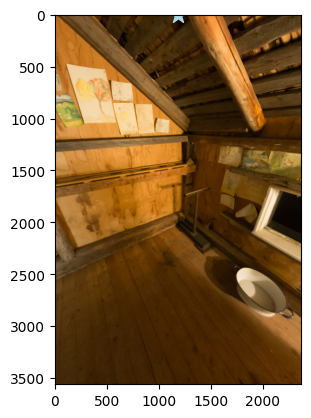

In [152]:
plt.imshow(im_a)
plt.scatter(B, 0, marker="*", c="lightblue", s=150)

In [ ]:
u_reprojected = (P_cam_new[0] * fx / P_cam_new[2]) + cx
v_reprojected = (P_cam_new[1] * fy / P_cam_new[2]) + cy

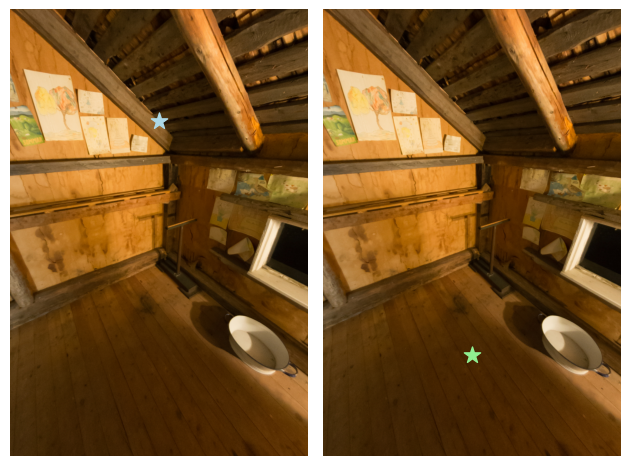

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(col_a, row_a, marker="*", c="lightblue", s=150)
ax1.imshow(im_a)
ax1.axis("off")
ax2.scatter(u_reprojected, v_reprojected, marker="*", c="lightgreen", s=150)
ax2.imshow(im_a)
ax2.axis("off")
plt.tight_layout()